
# <h1><center>Brittle Star Environment Tutorial</center></h1>

This notebook provides an introductory tutorial to the [Brittle Star environment](https://github.com/Co-Evolve/brt/tree/main/biorobot/brittle_star), which is part of the [**the Bio-inspired Robotics Testbed (BRT)**](https://github.com/Co-Evolve/brt).

Please make sure to read the above two linked github README pages in order to get an understanding of the rationale behind the Bio-inspired Robotics Testbed and some more background on the Brittle Star and the implemented tasks.

Preferably use a Jupyter runtime with GPU acceleration enabled.  

## Installation and setup 

In [1]:
import sys
!{sys.executable} -m pip install biorobot

Check if the underlying MuJoCo installation was successful. This will also check if Jax is able to find the GPU. If not, a warning will be printed.

In [2]:
import logging
import os
import subprocess

try:
    if subprocess.run('nvidia-smi').returncode:
        raise RuntimeError(
                'Cannot communicate with GPU. '
                'Make sure you are using a GPU Colab runtime. '
                'Go to the Runtime menu and select Choose runtime type.'
                )

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
            f.write(
                    """{
                            "file_format_version" : "1.0.0",
                            "ICD" : {
                                "library_path" : "libEGL_nvidia.so.0"
                            }
                        }
                        """
                    )

    # Configure MuJoCo to use the EGL rendering backend (requires GPU)
    print('Setting environment variable to use GPU rendering:')
    %env MUJOCO_GL=egl

    xla_flags = os.environ.get('XLA_FLAGS', '')
    xla_flags += ' --xla_gpu_triton_gemm_any=True'
    os.environ['XLA_FLAGS'] = xla_flags

    # Check if jax finds the GPU
    import jax

    print(jax.devices('gpu'))
except Exception:
    logging.warning("Failed to initialize GPU. Everything will run on the cpu.")

try:
    print('Checking that the mujoco installation succeeded:')
    import mujoco

    mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
    raise e from RuntimeError(
            'Something went wrong during installation. Check the shell output above '
            'for more information.\n'
            'If using a hosted Colab runtime, make sure you enable GPU acceleration '
            'by going to the Runtime menu and selecting "Choose runtime type".'
            )

print('MuJoCo installation successful.')

Sat Feb 10 17:06:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A2                      On  | 00000000:3B:00.0 Off |                    0 |
|  0%   52C    P8               9W /  60W |      0MiB / 15356MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Some packages and utility functions for visualization.

In [3]:
from moojoco.environment.base import MuJoCoEnvironmentConfiguration
from moojoco.mjcf.component import MJCFRootComponent
import numpy as np
import jax
import jax.numpy as jnp
from typing import List

# Graphics and plotting.
ffmpeg_v = !command -v ffmpeg
assert "command not found" not in ffmpeg_v, f"Please install FFmpeg for visualizations."
!{sys.executable} -m pip install -q mediapy
import mediapy as media

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)
jnp.set_printoptions(precision=3, suppress=True, linewidth=100)


def visualize_mjcf(
        mjcf: MJCFRootComponent
        ) -> None:
    model = mujoco.MjModel.from_xml_string(mjcf.get_mjcf_str())
    data = mujoco.MjData(model)
    renderer = mujoco.Renderer(model)
    mujoco.mj_forward(model, data)
    renderer.update_scene(data)
    media.show_image(renderer.render())


def post_render(
        render_output: List[np.ndarray],
        environment_configuration: MuJoCoEnvironmentConfiguration
        ) -> np.ndarray:
    if render_output is None:
        # Temporary workaround until https://github.com/google-deepmind/mujoco/issues/1379 is fixed
        return None

    num_cameras = len(environment_configuration.camera_ids)
    num_envs = len(render_output) // num_cameras

    if num_cameras > 1:
        # Horizontally stack frames of the same environment
        frames_per_env = np.array_split(render_output, num_envs)
        render_output = [np.concatenate(env_frames, axis=1) for env_frames in frames_per_env]

    # Vertically stack frames of different environments
    render_output = np.concatenate(render_output, axis=0)

    return render_output[:, :, ::-1]  # RGB to BGR


def show_video(
        images: List[np.ndarray | None]
        ) -> str | None:
    # Temporary workaround until https://github.com/google-deepmind/mujoco/issues/1379 is fixed
    filtered_images = [image for image in images if image is not None]
    num_nones = len(images) - len(filtered_images)
    if num_nones > 0:
        logging.warning(
            f"env.render produced {num_nones} None's. Resulting video might be a bit choppy (consquence of https://github.com/google-deepmind/mujoco/issues/1379)."
            )
    return media.show_video(images=filtered_images)

## Creating the brittle star environment

### 1. Creating the morphology 
The first step is to create the Brittle Star morphology. In essence, this comes down to providing an instance of a [BrittleStarMorphologySpecification](https://github.com/Co-Evolve/brt/tree/main/biorobot/brittle_star/mjcf/morphology/specification/specification.py#L78) to the [MJCFBrittleStarMorphology](https://github.com/Co-Evolve/brt/tree/main/biorobot/brittle_star/mjcf/morphology/morphology.py) class. The `MJCFBrittleStarMorphology` can then use the specified morphological parameters to generate the corresponding MuJoCo MJCF. 

In [4]:

from biorobot.brittle_star.mjcf.morphology.specification.default import default_brittle_star_morphology_specification
from biorobot.brittle_star.mjcf.morphology.morphology import MJCFBrittleStarMorphology
from biorobot.brittle_star.mjcf.morphology.specification.specification import BrittleStarMorphologySpecification


def create_morphology(
        morphology_specification: BrittleStarMorphologySpecification
        ) -> MJCFBrittleStarMorphology:
    morphology = MJCFBrittleStarMorphology(
            specification=morphology_specification
            )
    return morphology

""

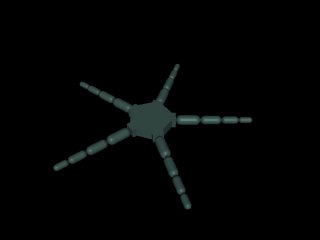

In [5]:
morphology_specification = default_brittle_star_morphology_specification(
        num_arms=5, num_segments_per_arm=4, use_p_control=True, use_torque_control=False
        )
morphology = create_morphology(morphology_specification=morphology_specification)
visualize_mjcf(mjcf=morphology)

We can also specify a different amount of segments per arm.

""

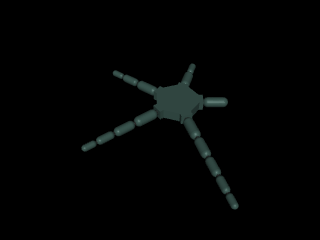

In [6]:
morphology_specification = default_brittle_star_morphology_specification(
        num_arms=5, num_segments_per_arm=[1, 2, 3, 4, 5], use_p_control=True, use_torque_control=False
        )
morphology = create_morphology(morphology_specification=morphology_specification)
visualize_mjcf(mjcf=morphology)

### 2. Creating the arena
Similarly to the morphology, the next step is to configure and create the AquariumArena in which we will put our brittle star. This arena uses a [simplified fluid model](https://mujoco.readthedocs.io/en/stable/computation/fluid.html#inertia-model) to simulate an aquatic environment.

In [7]:
from biorobot.brittle_star.mjcf.arena.aquarium import AquariumArenaConfiguration, MJCFAquariumArena


def create_arena(
        arena_configuration: AquariumArenaConfiguration
        ) -> MJCFAquariumArena:
    arena = MJCFAquariumArena(
            configuration=arena_configuration
            )
    return arena

""

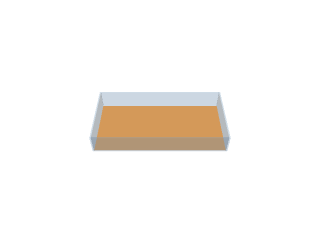

In [8]:
arena_configuration = AquariumArenaConfiguration(
        size=(10, 5), sand_ground_color=True, attach_target=False, wall_height=1.5, wall_thickness=0.1
        )
arena = create_arena(arena_configuration=arena_configuration)
visualize_mjcf(mjcf=arena)

### 3. Creating the environment
Now we can create the actual environment that combines the above morphology and arena. As discussed above, we have three different environment versions (each specifying a specific task) in which we can put our brittle star. Each version has a specific EnvironmentConfiguration.

In [9]:
from biorobot.brittle_star.environment.light_escape.shared import BrittleStarLightEscapeEnvironmentConfiguration
from biorobot.brittle_star.environment.directed_locomotion.shared import \
    BrittleStarDirectedLocomotionEnvironmentConfiguration
from biorobot.brittle_star.environment.undirected_locomotion.shared import \
    BrittleStarUndirectedLocomotionEnvironmentConfiguration

locomotion_environment_configuration = BrittleStarUndirectedLocomotionEnvironmentConfiguration(
        # If this value is > 0 then we will add randomly sampled noise to the initial joint positions and velocities 
        joint_randomization_noise_scale=0.0,
        render_mode="rgb_array",
        # Visualization mode 
        simulation_time=5,
        # Number of seconds per episode 
        num_physics_steps_per_control_step=10,
        # Number of physics substeps to do per control step 
        time_scale=2,
        # Integer factor by which to multiply the original physics timestep of 0.002,
        camera_ids=[0, 1],
        # Which camera's to render (all the brittle star environments contain 2 cameras: 1 top-down camera and one close-up camera that follows the brittle star),
        render_size=(480, 640)
        # Resolution to render with ((height, width) in pixels)
        )
target_locomotion_environment_configuration = BrittleStarDirectedLocomotionEnvironmentConfiguration(
        # Distance to put our target at (targets are spawned on a circle around the starting location with this given radius).
        target_distance=3.0,
        joint_randomization_noise_scale=0.0,
        render_mode="rgb_array",
        simulation_time=5,
        num_physics_steps_per_control_step=10,
        time_scale=2,
        camera_ids=[0, 1],
        render_size=(480, 640)
        )
light_escape_environment_configuration = BrittleStarLightEscapeEnvironmentConfiguration(
        # If this value is > 0, we will add perlin noise to the generated light map. Otherwise, the light map is a simple linear gradient.
        #   Please only provide integer factors of 200.
        light_perlin_noise_scale=0,
        joint_randomization_noise_scale=0,
        render_mode="rgb_array",
        simulation_time=5,
        num_physics_steps_per_control_step=10,
        time_scale=2,
        camera_ids=[0, 1],
        render_size=(480, 640)
        )

The [environment configuration's superclass](https://github.com/Co-Evolve/moojoco/blob/main/moojoco/environment/base.py#L20) also contains some helpful utility functions. 

Note: we define a 'physics step' as one in which the physics is advanced, and we define a 'control step' as one in which we pass novel actions to the environment. One 'control step' can thus induce one or multiple underlying 'physics steps', and this is what the `num_physics_steps_per_control_step` parameter defines.

In [10]:
print(
    f"[simulation_time] The total amount of time (in seconds) that one simulation episode takes: {locomotion_environment_configuration.simulation_time}"
    )
print(
    f"[physics_timestep] The amount of time (in seconds) that one 'physics step' advances the physics: {locomotion_environment_configuration.physics_timestep}"
    )
print(
    f"[control_timestep] The amount of time (in seconds) that one 'control step' advances the physics: {locomotion_environment_configuration.control_timestep}"
    )
print(
    f"[total_num_physics_steps] The total amount of physics steps that happen during one simulation episode: {locomotion_environment_configuration.total_num_physics_steps}"
    )
print(
    f"[total_num_control_steps] The total amount of control steps that happen during one simulation episode: {locomotion_environment_configuration.total_num_control_steps}"
    )

[simulation_time] The total amount of time (in seconds) that one simulation episode takes: 5
[physics_timestep] The amount of time (in seconds) that one 'physics step' advances the physics: 0.004
[control_timestep] The amount of time (in seconds) that one 'control step' advances the physics: 0.04
[total_num_physics_steps] The total amount of physics steps that happen during one simulation episode: 1250
[total_num_control_steps] The total amount of control steps that happen during one simulation episode: 125


#### Creator
We can now define a function that takes in a certain morphological specification, the arena configuration and the environment configuration and returns the actual environment. Note that we have added an additional argument to this function,`backend`, which can be used to choose between instantiating the MJC (native MuJoCo) or the MJX (JAX-based MuJoCo) implementation of the environment.

In [11]:
from biorobot.brittle_star.environment.undirected_locomotion.dual import BrittleStarUndirectedLocomotionEnvironment
from biorobot.brittle_star.environment.directed_locomotion.dual import BrittleStarDirectedLocomotionEnvironment
from biorobot.brittle_star.environment.light_escape.dual import BrittleStarLightEscapeEnvironment
from moojoco.environment.dual import DualMuJoCoEnvironment
from moojoco.environment.base import MuJoCoEnvironmentConfiguration


def create_environment(
        morphology_specification: BrittleStarMorphologySpecification,
        arena_configuration: AquariumArenaConfiguration,
        environment_configuration: MuJoCoEnvironmentConfiguration,
        backend: str
        ) -> DualMuJoCoEnvironment:
    assert backend in ["MJC", "MJX"], "Please specify a valid backend; Either 'MJC' or 'MJX'"

    morphology = create_morphology(
            morphology_specification=morphology_specification
            )
    arena = create_arena(
            arena_configuration=arena_configuration
            )
    if isinstance(environment_configuration, BrittleStarUndirectedLocomotionEnvironmentConfiguration):
        env_class = BrittleStarUndirectedLocomotionEnvironment
    elif isinstance(environment_configuration, BrittleStarDirectedLocomotionEnvironmentConfiguration):
        env_class = BrittleStarDirectedLocomotionEnvironment
    else:
        env_class = BrittleStarLightEscapeEnvironment

    env = env_class.from_morphology_and_arena(
            morphology=morphology, arena=arena, configuration=environment_configuration, backend=backend
            )
    return env

Given the above utility functions, the next code snippet instantiates the environment and renders a single frame. 
Use this to test the influence of different parameters and configurations.

""

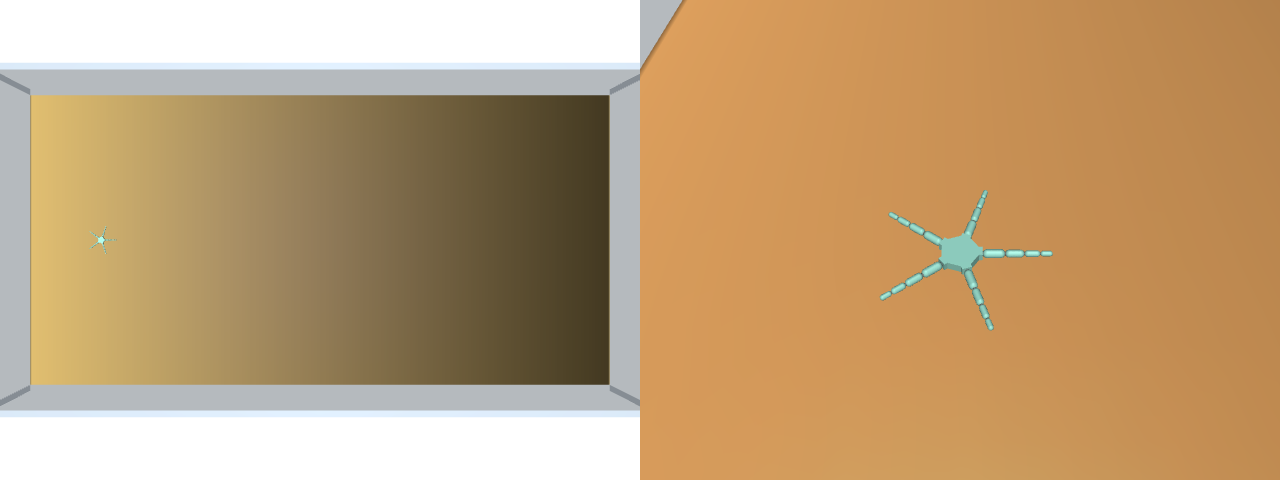

In [12]:
morphology_specification = default_brittle_star_morphology_specification(
        num_arms=5, num_segments_per_arm=4, use_p_control=True, use_torque_control=False
        )
arena_configuration = AquariumArenaConfiguration(
        size=(10, 5), sand_ground_color=True, attach_target=False, wall_height=1.5, wall_thickness=0.1
        )
environment_configuration = BrittleStarLightEscapeEnvironmentConfiguration(
        joint_randomization_noise_scale=0.0,
        light_perlin_noise_scale=0,
        render_mode="rgb_array",
        simulation_time=5,
        num_physics_steps_per_control_step=10,
        time_scale=2,
        camera_ids=[0, 1],
        render_size=(480, 640)
        )

BACKEND = "MJC"

env = create_environment(
        morphology_specification=morphology_specification,
        arena_configuration=arena_configuration,
        environment_configuration=environment_configuration,
        backend=BACKEND
        )

if BACKEND == "MJC":
    rng = np.random.RandomState(0)
else:
    rng = jax.random.PRNGKey(seed=0)

state = env.reset(rng=rng)  # Always need to reset the environment before doing anything else with it
frame = env.render(state=state)
media.show_image(post_render(render_output=frame, environment_configuration=environment_configuration))
env.close()  # always close the environment after using it!

## Using the environment
In this section we will check how we can now actually use the environments. Let's start by instantiating both an MJC and MJX variant.

In [13]:
mjc_env = create_environment(
        morphology_specification=morphology_specification,
        arena_configuration=arena_configuration,
        environment_configuration=environment_configuration,
        backend="MJC"
        )
mjx_env = create_environment(
        morphology_specification=morphology_specification,
        arena_configuration=arena_configuration,
        environment_configuration=environment_configuration,
        backend="MJX"
        )

### Observation space
The observation describes the dimensionality and range of the observations that the environment returns upon reset and after taking a step. As both the MJC and MJX variants implement the same environment, although with a different backend, they have the same observation space (order in which different observations are printed might be a bit different though).

In [14]:
print("MJC:")
print(f"\t{mjc_env.observation_space}")
print("MJX:")
print(f"\t{mjx_env.observation_space}")

MJC:
	Dict('disk_angular_velocity': Box(-inf, inf, (3,), float32), 'disk_linear_velocity': Box(-inf, inf, (3,), float32), 'disk_position': Box(-inf, inf, (3,), float32), 'disk_rotation': Box(-3.1415927, 3.1415927, (3,), float32), 'joint_actuator_force': Box(-inf, inf, (40,), float32), 'joint_position': Box(-0.5235988, 0.5235988, (40,), float32), 'joint_velocity': Box(-inf, inf, (40,), float32), 'segment_contact': Box(0.0, 1.0, (20,), float32), 'segment_light_intake': Box(0.0, 1.0, (20,), float32))
MJX:
	Dict('joint_position': Box(-0.5235988, 0.5235988, (40,), <class 'jax.numpy.float32'>), 'joint_velocity': Box(-inf, inf, (40,), <class 'jax.numpy.float32'>), 'joint_actuator_force': Box(-inf, inf, (40,), <class 'jax.numpy.float32'>), 'segment_contact': Box(0.0, 1.0, (20,), <class 'jax.numpy.float32'>), 'disk_position': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'disk_rotation': Box(-3.1415927, 3.1415927, (3,), <class 'jax.numpy.float32'>), 'disk_linear_velocity': Box(-inf, inf, (

### Action space
The action space describes the dimensionality and range of actions the environment expects in order to take a step. In essence, the environment maps each given action to the control signal of an actuator. Each joint is given an actuator that can control the joints position (either directly through position actuators or indirectly through torque actuators). For the in-plane joints, a positive actuator signal means that the segment will point leftwards (when looking at the segment from the central disc), and rightwards for a negative actuator signal. For the out-of-plane joints, a positive actuator signal means that the segment will point upwards and downwards for a negative actuator signal. 

In [15]:
print("MJC:")
print(f"\t{mjc_env.action_space}")
print("MJX:")
print(f"\t{mjx_env.action_space}")

MJC:
	Box(-0.5235988, 0.5235988, (40,), float32)
MJX:
	Box(-0.5235988, 0.5235988, (40,), <class 'jax.numpy.float32'>)


To help in knowing which action is mapped to which actuator, the following call returns a list of actuator names such that `actions[i]` is mapped to `actuator[i]`. This order is always the same between MJC and MJX.

In [16]:
print("First 5 actuators:")
print(f"\tMJC: {mjc_env.actuators[:5]}")
print(f"\tMJX: {mjx_env.actuators[:5]}")

First 5 actuators:
	MJC: ['BrittleStarMorphology/arm_0_segment_0_in_plane_joint_p_control', 'BrittleStarMorphology/arm_0_segment_0_out_of_plane_joint_p_control', 'BrittleStarMorphology/arm_0_segment_1_in_plane_joint_p_control', 'BrittleStarMorphology/arm_0_segment_1_out_of_plane_joint_p_control', 'BrittleStarMorphology/arm_0_segment_2_in_plane_joint_p_control']
	MJX: ['BrittleStarMorphology/arm_0_segment_0_in_plane_joint_p_control', 'BrittleStarMorphology/arm_0_segment_0_out_of_plane_joint_p_control', 'BrittleStarMorphology/arm_0_segment_1_in_plane_joint_p_control', 'BrittleStarMorphology/arm_0_segment_1_out_of_plane_joint_p_control', 'BrittleStarMorphology/arm_0_segment_2_in_plane_joint_p_control']


### Running and visualizing an episode
Now we will run the simulation environment and visualize it. As shown below, this happens in a similar manner for both the MJC and the MJX variants, as both follow the interface defined in [moojoco](https://github.com/Co-Evolve/moojoco/blob/main/moojoco/environment/base.py). This interface follows the functional programming paradigm. Put simply, this means that we rely only on pure functions (i.e. functions that are deterministic and without side effects). Consequently, when interacting with the environment, we will always have an explicit environment state that is passed around (instead of relying on the environment to adapt its state). The main difference between the MJC and MJX variants is that the MJC variant uses [MJCEnvState](https://github.com/Co-Evolve/moojoco/blob/main/moojoco/environment/mjc_env.py#L29) (which contains Numpy arrays and Numpy's random states), while the MJX variant uses [MJXEnvState](https://github.com/Co-Evolve/moojoco/blob/main/moojoco/environment/mjx_env.py#L58) (which contains JAX arrays and JAX's random number generators).

The most important variables stored in the environment state are:
- `observations`: a dictionary mapping an observation's identifier to its values
- `terminated`: boolean value that denotes whether the episode is terminated (e.g. because the goal was reached)
- `truncated`: boolean value that denotes whether the episode was truncated (e.g. because the time limit was reached)
- `reward`: float value that denotes the reward of doing the given actions in the previous state
- `info`: a dictionary that the environment can use to pass additional information to the user
- `rng`: the current random number generator's state

Note1: Always reset the environment when the current episode has been terminated or truncated.
Note2: When rendering the environment, you might want to increase the resolution to increase visibility (rendering will be slower then though). This can be done through the [environment configuration](https://github.com/Co-Evolve/moojoco/blob/main/moojoco/environment/base.py#L29)'s `render_size` attribute, which denotes the `(height, width)` in pixels.

#### MJC

In [17]:
mjc_env_rng = np.random.RandomState(seed=0)

mjc_state = mjc_env.reset(rng=mjc_env_rng)

mjc_frames = []
while not (mjc_state.terminated | mjc_state.truncated):
    action = mjc_env.action_space.sample()
    mjc_state = mjc_env.step(state=mjc_state, action=action)
    mjc_frames.append(post_render(mjc_env.render(state=mjc_state), mjc_env.environment_configuration))
show_video(images=mjc_frames)

#### MJX
The first time that you run this cell will take a while because of the JIT-compilation. Subsequent calls will however go faster.
Note: As discussed further below, MJX always runs much slower than MJC when running only a single environment (even after jitting) and especially when rendering every step! MJX only shines when we're running many environments simultaneously and skip the rendering.

In [18]:
rng = jax.random.PRNGKey(seed=0)
mjx_env_rng, action_rng = jax.random.split(rng, 2)

jit_step = jax.jit(mjx_env.step)
jit_reset = jax.jit(mjx_env.reset)

mjx_state = jit_reset(rng=mjx_env_rng)

mjx_frames = []
while not (mjx_state.terminated | mjx_state.truncated):
    action_rng, sub_rng = jax.random.split(action_rng, 2)
    action = mjx_env.action_space.sample(rng=sub_rng)

    mjx_state = jit_step(state=mjx_state, action=action)
    mjx_frames.append(post_render(mjx_env.render(state=mjx_state), mjx_env.environment_configuration))
show_video(images=mjx_frames)

Avoid memory leaks and always close your environment after using!

In [19]:
mjc_env.close()
mjx_env.close()

### Vectorization
During optimization we often want multiple environments to run in parallel as this increases data collection speed. For instance with evolutionary optimization, this allows to evaluate multiple candidate solutions in parallel. Alternatively in the reinforcement learning setting, this can be used to simultaneously collect data from slightly different environment versions if we use randomization or noise.

#### MJC
MJC runs on the CPU, so when we want to run multiple instances of the environment in parallel, we can choose between multithreading and multiprocessing. In this case, we'll go for multiprocessing and use mujoco-utils' [ThreadedVectorMJCEnvWrapper](https://github.com/Co-Evolve/moojoco/blob/main/moojoco/environment/mjc_env.py#L170). Given [Python's Global Interpreter Lock](https://wiki.python.org/moin/GlobalInterpreterLock), the environment's python code will thus not run truly in parallel; the underlying calls to the MuJoCo physics engine however will. When vectorizing over the CPU, we often use one environment instance for CPU core available.

In [20]:
from moojoco.environment.mjc_env import ThreadedVectorMJCEnvWrapper

NUM_MJC_ENVIRONMENTS = 2  # set this to the number of CPU cores that you have available 

mjc_vectorized_env = ThreadedVectorMJCEnvWrapper(
        lambda: create_environment(
                morphology_specification=morphology_specification,
                arena_configuration=arena_configuration,
                environment_configuration=environment_configuration,
                backend="MJC"
                ), num_environments=NUM_MJC_ENVIRONMENTS
        )

mjc_vectorized_env_rng = [np.random.RandomState(seed=i) for i in range(NUM_MJC_ENVIRONMENTS)]

mjc_vectorized_state = mjc_vectorized_env.reset(rng=mjc_vectorized_env_rng)

mjc_frames = []
while not np.any(mjc_vectorized_state.terminated | mjc_vectorized_state.truncated):
    action = mjc_vectorized_env.action_space.sample()
    mjc_vectorized_state = mjc_vectorized_env.step(state=mjc_vectorized_state, action=action)
    mjc_frames.append(
            post_render(
                    mjc_vectorized_env.render(state=mjc_vectorized_state), mjc_vectorized_env.environment_configuration
                    )
            )
show_video(images=mjc_frames)

As illustrated below by the adapted `observation_space` and `action_space`, our environment will now return a batched version of the original observations, and expect a batched version of the original actions. Each sample in these batches corresponds to the observations and actions of a single underlying environment.

In [21]:
print("Observation space:")
print(f"\t{mjc_vectorized_env.observation_space}")
print("Action space:")
print(f"\t{mjc_vectorized_env.action_space}")

Observation space:
	Dict('disk_angular_velocity': Box(-inf, inf, (2, 3), float32), 'disk_linear_velocity': Box(-inf, inf, (2, 3), float32), 'disk_position': Box(-inf, inf, (2, 3), float32), 'disk_rotation': Box(-3.1415927, 3.1415927, (2, 3), float32), 'joint_actuator_force': Box(-inf, inf, (2, 40), float32), 'joint_position': Box(-0.5235988, 0.5235988, (2, 40), float32), 'joint_velocity': Box(-inf, inf, (2, 40), float32), 'segment_contact': Box(0.0, 1.0, (2, 20), float32), 'segment_light_intake': Box(0.0, 1.0, (2, 20), float32))
Action space:
	Box(-0.5235988, 0.5235988, (2, 40), float32)


#### MJX

The MJX environment can also be vectorized on the CPU, but it's main performance advantage comes from parallelization on the GPU (which JAX enables). MJX basically implements environment / physics steps as operator over big Jax arrays (e.g. an array of all current joint positions, one with all current joint velocities, ...). To parallelize, it just adds an additional batch dimension over these arrays via [jax.vmap](https://jax.readthedocs.io/en/latest/jax-101/03-vectorization.html). When vectorizing over the GPU, we often run one environment instance per CUDA core available (this can be found on your GPU's datasheet). The cool thing is that a single GPU has a lot more of these cores than the number of CPU cores your computer (or even a regular cluster) has. 

As a rule-of-thumb:
- Use MJC when you want to run a single environment (e.g. to do a quick test or to visualize a single rollout).
- Use MJX when you (1) have a GPU available, and (2) are doing an optimization.
- Read: https://mujoco.readthedocs.io/en/stable/mjx.html#mjx-the-sharp-bits

Note: Rendering MJX environments requires the JAX datastructures (on the GPU) to be loaded back into the original MuJoCo structures (on the CPU). This datatransfer has a severe impact; So never render when collecting data during an optimization! (This rule also counts for MJC environments: rendering slows down everything, so only do it when necessary!)

In [22]:
NUM_MJX_ENVIRONMENTS = 2  # set this to the number of CUDA cores that you have available

mjx_vectorized_env = create_environment(
        morphology_specification=morphology_specification,
        arena_configuration=arena_configuration,
        environment_configuration=environment_configuration,
        backend="MJX"
        )

mjx_action_rng, mjx_vectorized_env_rng = jax.random.split(jax.random.PRNGKey(0), 2)
mjx_vectorized_env_rng = jnp.array(jax.random.split(mjx_vectorized_env_rng, NUM_MJX_ENVIRONMENTS))

mjx_vectorized_step = jax.jit(jax.vmap(mjx_vectorized_env.step))
mjx_vectorized_reset = jax.jit(jax.vmap(mjx_vectorized_env.reset))
mjx_vectorized_action_sample = jax.jit(jax.vmap(mjx_vectorized_env.action_space.sample))

In [23]:
mjx_vectorized_state = mjx_vectorized_reset(rng=mjx_vectorized_env_rng)

mjx_frames = []
while not jnp.any(mjx_vectorized_state.terminated | mjx_vectorized_state.truncated):
    mjx_action_rng, *sub_rngs = jnp.array(jax.random.split(mjx_action_rng, NUM_MJX_ENVIRONMENTS + 1))
    action = mjx_vectorized_action_sample(rng=jnp.array(sub_rngs))

    mjx_vectorized_state = mjx_vectorized_step(state=mjx_vectorized_state, action=action)
    mjx_frames.append(
            post_render(
                    mjx_vectorized_env.render(state=mjx_vectorized_state), mjx_vectorized_env.environment_configuration
                    )
            )
show_video(images=mjx_frames)

In [24]:
print("Observation space:")
print(f"\t{mjx_vectorized_env.observation_space}")
print("Action space:")
print(f"\t{mjx_vectorized_env.action_space}")

Observation space:
	Dict('joint_position': Box(-0.5235988, 0.5235988, (40,), <class 'jax.numpy.float32'>), 'joint_velocity': Box(-inf, inf, (40,), <class 'jax.numpy.float32'>), 'joint_actuator_force': Box(-inf, inf, (40,), <class 'jax.numpy.float32'>), 'segment_contact': Box(0.0, 1.0, (20,), <class 'jax.numpy.float32'>), 'disk_position': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'disk_rotation': Box(-3.1415927, 3.1415927, (3,), <class 'jax.numpy.float32'>), 'disk_linear_velocity': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'disk_angular_velocity': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'segment_light_intake': Box(0.0, 1.0, (20,), <class 'jax.numpy.float32'>))
Action space:
	Box(-0.5235988, 0.5235988, (40,), <class 'jax.numpy.float32'>)


In [25]:
mjc_vectorized_env.close()
mjx_vectorized_env.close()

## Exercise
Play around with the different brittle star environments. Take a closer look at the different observations, try to do a speed comparison between MJC and MJX environments, ...